## Case 2：應用淹水脆弱度圖資與土地覆蓋圖資計算淹水面積

#### 空間解析度40m之淹水脆弱度圖資可理解為地文條件承受雨量衝擊的能力，其物理量為累積雨量mm，當降雨量超過脆弱度時表示出現致災雨量導致淹水。

#### 土地覆蓋圖資將影像中的每個像素分為水體、樹木、草地、濕地植物、農作物、灌木、建設用地、裸露地、雪地等9大類。

#### 本案例將計算累積雨量到達一定量時各土地覆蓋類型之淹水面積並繪製統計圖

<div style="display: inline-block;">
    <img src="https://github.com/GISFCU-TM/GDXP-Demo/blob/main/flooding.png?raw=true" alt="Flooding_Vurnerbility" width="280"/>
    <p style="text-align: center;">淹水脆弱度圖資</p>
</div>
<div style="display: inline-block;"> 
    <img src="https://github.com/GISFCU-TM/GDXP-Demo/blob/main/LC.png?raw=true" alt="LANDUSE" width="280"/>
    <p style="text-align: center;">土地覆蓋圖資</p>      
</div>

In [61]:
import matplotlib
matplotlib.rc('font', family='Microsoft JhengHei') # 設定中文字形
from PIL import Image, ImageDraw
from io import BytesIO
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

import requests
import numpy as np
import urllib3
urllib3.disable_warnings()

In [62]:
#GDXP帳號及介接安全碼
%store -r username
%store -r token
#GDXP URL
%store -r gdxp1
%store -r gdxp2

In [63]:
#淹水圖資套用color map (取用淹水門檻0.1m延時雨量24hr之圖資)
queryflooding1='''
for $c in (Flooding_Vurnerbility_by_Accumulation_Rainfall_24hr)
 return encode(
             $c.E24hr0p1m[ansi("2023-05-01")]        
        , "tiff",
        "{\\\"colorMap\\\":{\\\"type\\\":\\\"intervals\\\",\\\"colorTable\\\":{\\\"0\\\":[220,220,220,255],\\\"50\\\":[190,236,234,255],\\\"100\\\":[133,212,227,255],\\\"200\\\":[27,142,186,255],\\\"300\\\":[7,83,141,255],\\\"400\\\":[11,48,93,255],\\\"500\\\":[13,19,45,255]}},\\\"nodata\\\":[0]}"
        )'''

In [64]:
#淹水圖資 (取用淹水門檻0.1m延時雨量24hr之圖資)
queryflooding='''
for $c in (Flooding_Vurnerbility_by_Accumulation_Rainfall_24hr)
 return encode(
             $c.E24hr0p1m[ansi("2023-05-01")]        
        , "tiff"
        )'''

In [65]:
#土地覆蓋圖資(clipping against polygon provided in WKT representation)
querylanduse='''
for $c in (LANDUSE_51Q_20200101_20210101)
return
  encode(
    clip( $c[ansi("2021-01-01T00:00:00.000Z")] ,
          POLYGON((
            162018.5 2486300.5, 
            162018.5 2549260.5, 
            195498.5 2549260.5,
            195498.5 2486300.5                     
          )),
          "http://localhost:8080/rasdaman/def/crs/EPSG/0/3826"
    ),
    "tiff"
  )
'''

In [66]:
# 送出 request
responseflooding = requests.post(gdxp2, data = {'query': queryflooding}, verify=False, auth = (username, token))
responseflooding1 = requests.post(gdxp2, data = {'query': queryflooding1}, verify=False, auth = (username, token))
responselanduse = requests.post(gdxp1, data = {'query': querylanduse}, verify=False, auth = (username, token))


In [67]:
# response.content將 Response 轉成 bytes 型態
floodingimg = Image.open(BytesIO(responseflooding.content))
floodingimg1 = Image.open(BytesIO(responseflooding1.content))
landuseimg = Image.open(BytesIO(responselanduse.content))
landuseimg = landuseimg.resize(floodingimg.size, Image.LANCZOS)


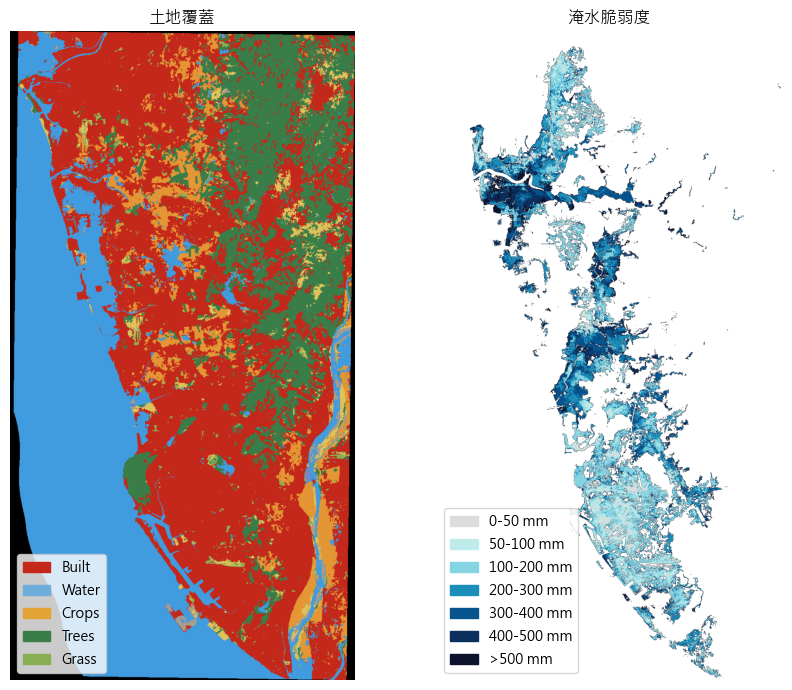

In [68]:
fig, ax = plt.subplots(1,2,figsize=(9, 7))  # 設定繪圖介面的大小

ax[0].set_title('土地覆蓋')
ax[0].imshow(landuseimg)
ax[0].axis('off')
Built = mpatches.Patch(color='#c4281b', label='Built')
Water = mpatches.Patch(color='#6eacdb', label='Water')
Crops = mpatches.Patch(color='#e4a435', label='Crops')
Trees = mpatches.Patch(color='#397d49', label='Trees')
Grass = mpatches.Patch(color='#88b053', label='Grass')
ax[0].legend(handles=[Built,Water,Crops,Trees,Grass], loc='lower left')

ax[1].set_title('淹水脆弱度')
ax[1].imshow(floodingimg1)
ax[1].axis('off')
lv0 = mpatches.Patch(color='#dcdcdc', label='0-50 mm')
lv1 = mpatches.Patch(color='#beecea', label='50-100 mm')
lv2 = mpatches.Patch(color='#85d4e3', label='100-200 mm')
lv3 = mpatches.Patch(color='#1b8eba', label='200-300 mm')
lv4 = mpatches.Patch(color='#07538d', label='300-400 mm')
lv5 = mpatches.Patch(color='#0b305d', label='400-500 mm')
lv6 = mpatches.Patch(color='#0d132d', label='>500 mm')
ax[1].legend(handles=[lv0,lv1,lv2,lv3,lv4,lv5,lv6], loc='lower left')

plt.tight_layout()
plt.show()


In [69]:
landuse = np.asarray(landuseimg)
flooding = np.asarray(floodingimg)

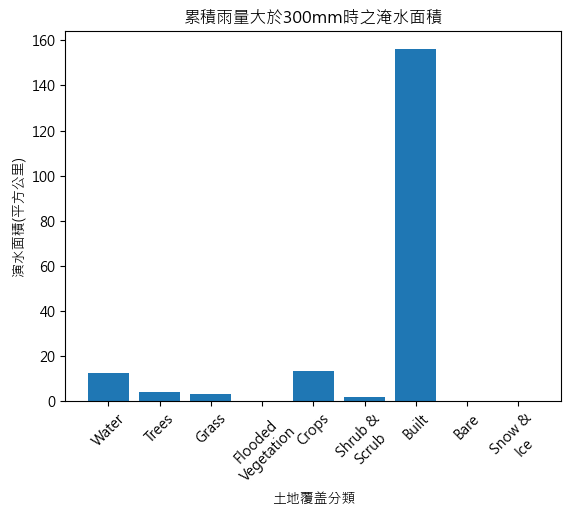

In [70]:
landuse_flat = landuse.flatten()
flooding_flat = flooding.flatten()

#landuse：9-->Snow & Ice, 8-->Bare, 7-->Built, 6-->Shrub & Scrub, 5-->Crops, 4-->Flooded Vegetation, 3-->Grass, 2-->Trees, 1-->Water
landuse_count = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}

# 計算淹水面積(1pixel-->0.0016km2)
for lu, flood in zip(landuse_flat, flooding_flat):
    if (flood > 0) and (flood < 300):
        landuse_count[lu] += 0.0016

        
# 提取横坐標和縱坐標的值
landuse_values = list(landuse_count.keys())[1:10]
flooding_counts = list(landuse_count.values())[1:10]

# 統計圖
landuse_labels = ['Water', 'Trees', 'Grass', 'Flooded\nVegetation', 'Crops', 'Shrub &\nScrub', 'Built', 'Bare', 'Snow &\nIce']

plt.bar(landuse_values, flooding_counts, tick_label=landuse_labels)
plt.xlabel('土地覆盖分類')
plt.ylabel('演水面積(平方公里)')
plt.title('累積雨量大於300mm時之淹水面積')
plt.xticks(rotation=45)
plt.show()